Natural Language Processing  
author: D.Thébault

Based on NLP Demystified (YouTube) https://nlpdemystified.org


Define the environment in python3:  
virtualenv -p /usr/bin/python3 env
brew update

Install Python 3.11 with Homebrew  
brew install python@3.11

Create a virtual environment with Python 3.11  
python3.11 -m venv myenv

Activate the virtual environment  
source myenv/bin/activate

Install the packages  
pip install numpy h5py spacy
pip install ipykernel  
python -m spacy download en_core_web_sm  
python -m spacy info


# Part I: Fundamentals of NLP

## **Building Models**

### **Reminders**

In [92]:
# TF-IDF

# Another BOW

import spacy

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the corpus
corpus = fetch_20newsgroups(categories=['sci.space'],remove=('headers', 'footers', 'quotes'))
# print the first two posts
print(corpus.data[:2])

# A bunch is not structured (no fixe columns) but as a known number of rows:
print(len(corpus.data))

["\nAny lunar satellite needs fuel to do regular orbit corrections, and when\nits fuel runs out it will crash within months.  The orbits of the Apollo\nmotherships changed noticeably during lunar missions lasting only a few\ndays.  It is *possible* that there are stable orbits here and there --\nthe Moon's gravitational field is poorly mapped -- but we know of none.\n\nPerturbations from Sun and Earth are relatively minor issues at low\naltitudes.  The big problem is that the Moon's own gravitational field\nis quite lumpy due to the irregular distribution of mass within the Moon.", '\nGlad to see Griffin is spending his time on engineering rather than on\nritual purification of the language.  Pity he got stuck with the turkey\nrather than one of the sensible options.']
593


In [83]:
%%time

# Preprocessing: creating TF-IDF Features

nlp = spacy.load('en_core_web_sm')

# We don't need named-entity recognition nor dependency parsing in the pipeline. 
# We do need part-of-speech tagging however.
unwanted_pipes = ["ner", "parser"]

# Preprocessing
# For this exercise, we'll remove punctuation and spaces (which
# includes newlines), filter for tokens consisting of alphabetic
# characters, and return the lemma (which require POS tagging).
def spacy_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            t.is_alpha]

# Use the default settings of TfidfVectorizer.
# We transform the corpus of documents into a matrix of caracteristics TF-IDF
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
features = vectorizer.fit_transform(corpus.data)

# The number of unique tokens.
print(len(vectorizer.get_feature_names_out()))

# The dimensions of our feature matrix. X rows (documents) by Y columns (tokens).
print(features.shape)

# We use the Pandas library to visualize the matrix of TF-IDF caracteristics
# View the first rows of the vectorized doc
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.DataFrame(features.toarray(), columns = vectorizer.get_feature_names_out()).head(2)

print(df)
print(df.shape)

9463
(593, 9463)
     I         a  aan  aangegeven  aantal  aao  aarseth  aas  aavso   ab  \
0  0.0  0.032025  0.0         0.0     0.0  0.0      0.0  0.0    0.0  0.0   
1  0.0  0.000000  0.0         0.0     0.0  0.0      0.0  0.0    0.0  0.0   

   abandon  abbreviation  abc  abian  ability  able  abn  aboard  abort  \
0      0.0           0.0  0.0    0.0      0.0   0.0  0.0     0.0    0.0   
1      0.0           0.0  0.0    0.0      0.0   0.0  0.0     0.0    0.0   

   aborted  about  above  abruptly  absolute  absolutely  absorb  absorber  \
0      0.0    0.0    0.0       0.0       0.0         0.0     0.0       0.0   
1      0.0    0.0    0.0       0.0       0.0         0.0     0.0       0.0   

   absorbtion  absorption  abstract  absurd  abundance  abuse  abutaha  abyss  \
0         0.0         0.0       0.0     0.0        0.0    0.0      0.0    0.0   
1         0.0         0.0       0.0     0.0        0.0    0.0      0.0    0.0   

    ac  academic  academically  academy  accelera

In [84]:
# Querying the data (the documents)

# View the 5th row of the columns 'lunar' & 'orbit' in the matrix of TF-IDF:
print(pd.DataFrame(features.toarray(), columns = vectorizer.get_feature_names_out()).loc[:3,['lunar','orbit']])

# 1. Transform the query into a TF-IDF vector.
# using the same vocabulary from our fit step on our corpus
query = ["lunar orbit"]
query_tfidf = vectorizer.transform(query)
print(query_tfidf.shape)

# 2. Calculate the cosine similarities between the query and each document.
# We're calling flatten() here becaue cosine_similarity returns a list
# of lists and we just want a single list.
cosine_similarities = cosine_similarity(features, query_tfidf).flatten()

# Function to take the k highest similarities
import numpy as np

# numpy's argsort() method returns a list of *indices* that
# would sort an array:
# https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
#
# The sort is ascending, but we want the largest k cosine_similarites
# at the bottom of the sort. So we negate k, and get the last k
# entries of the indices list in reverse order. There are faster
# ways to do this using things like argpartition but this is
# more succinct.
def top_k(arr, k):
  kth_largest = (k + 1) * -1
  return np.argsort(arr)[:kth_largest:-1]

# So for our query above, these are the top five documents.
# The most similar with our query:
top_related_indices = top_k(cosine_similarities, 5)
print(top_related_indices)

# Let's take a look at their respective cosine similarities.
print(cosine_similarities[top_related_indices])

# Top match.
print(corpus.data[top_related_indices[0]])

# Second-best match.
print(corpus.data[top_related_indices[1]])

      lunar     orbit
0  0.177557  0.215543
1  0.000000  0.000000
2  0.000000  0.000000
3  0.000000  0.000000
(1, 9463)
[249 108   0 312 509]
[0.47796463 0.42917994 0.27361651 0.19484941 0.19147591]

Actually, Hiten wasn't originally intended to go into lunar orbit at all,
so it indeed didn't have much fuel on hand.  The lunar-orbit mission was
an afterthought, after Hagoromo (a tiny subsatellite deployed by Hiten
during a lunar flyby) had a transmitter failure and its proper insertion
into lunar orbit couldn't be positively confirmed.

It should be noted that the technique does have disadvantages.  It takes
a long time, and you end up with a relatively inconvenient lunar orbit.
If you want something useful like a low circular polar orbit, you do have
to plan to expend a certain amount of fuel, although it is reduced from
what you'd need for the brute-force approach.

Their Hiten engineering-test mission spent a while in a highly eccentric
Earth orbit doing lunar flybys, and then was i

## 4. **Modelling Overview**

Finding Patterns for Fun and Profit.  

- Four different types of machine learning.

- Train / validation / test splits.

- Bias vs. Variance.

- Overfitting vs. underfitting.

- Concepts of regularization and hyperparameters.

- Practical concerns beyond evaluation metrics.  

We skip this video :)

Types of Machine Learning algorithms vs models, evaluation...

## 5. **First steps into Text Classification**

Classifying text using Naive Bayes; evaluation with precision and recall.

### 5.1. **Naive Bayes**

Fast and Simple for Text Classification.  

Exemples of classification:
- Product review sentiment (postive or negative)
- Support ticket categorization (billing, service change or repair)
- ...

$\mathbb{P}(A \cap B) = \mathbb{P}(A) \times \mathbb{P}(B | A)$  

$\mathbb{P}(B \cap A) = \mathbb{P}(B) \times \mathbb{P}(A | B)$  

$\Rightarrow \mathbb{P}(A) \times \mathbb{P}(B | A) = \mathbb{P}(B) \times \mathbb{P}(A | B)$

**Bayes'Theorem:**  

$\mathbb{P}(A | B) =  \frac{\mathbb{P}(A) \times \mathbb{P}(B | A)}{\mathbb{P}(B)}$  

<u>Where:</u>  
$\mathbb{P}(A | B)$ the posterior  
$\mathbb{P}(A)$ the prior  
$\mathbb{P}(B | A)$ the likelihood  
$\mathbb{P}(B)$ the normalizing constant

In [85]:
os.getcwd()

'/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy'

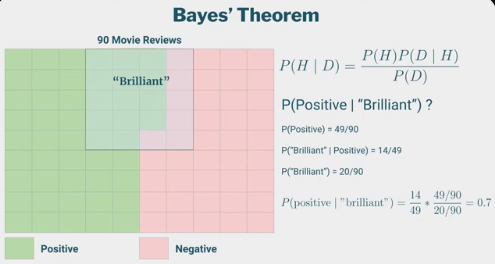

In [86]:
from IPython import display
display.Image(r"./png/Bayes_exemple.png")

Apply to text classification: 

$\mathbb{P}(\; c \; | \;  d) =  \frac{\mathbb{P}(c) \times \mathbb{P}(\;d\; | \;c\;)}{\mathbb{P}(d)}$  

Where:  

- $c$ is the class, 

- $d$ the document.

- $\mathbb{P}(c) = \frac{\text{Number of documents of class c}}{\text{Total number of documents}}$ 

- $\mathbb{P}(d \; | \;c) = \mathbb{P}([w_1, w_2,\ldots, w_n] \; | \;c)$ the likelihood

- $\mathbb{P}(d \; | \;c)$ the normalizing constant


**Specifically, find the class which maximizes the posterior possibility (i.e. the most probable class).**  

$\underset{c \in C}{argmax} \; \mathbb{P}(c \; | \; d) =  \underset{c \in C}{argmax} \; \frac{\mathbb{P}(c) \times \mathbb{P}(d \; | \;c)}{\mathbb{P}(d)}$  

We eliminate the normalizing constant:  

$\hat{c} = \underset{c \in C}{argmax} \; \mathbb{P}(c \; | \; d) =  \underset{c \in C}{argmax} \; \mathbb{P}(c) \times \mathbb{P}(d \; | \; c)$  

We are looking for the class $\hat{c} \; $ that maximize this probability i.e. is the most probable class.

The likelihood as it stands is difficult to calculate:  

$\mathbb{P}(d \; | \;c) = \mathbb{P}([w_1, w_2,\ldots, w_n] \; | \;c)$

We will need a large amount of data.  
So we will simplify the calculation with two asumptions:  

1. Word order does not matter, so we use BOW representations
2. Word appearances are independant of each other givent a particular class.  

The terme naïve comes from the the second asumptions. It does not hold at all in real life.  
For exemple "thank" "you" are correlated.  



$\mathbb{P}(d \;| \;c) = \mathbb{P}(w_1 \; | \;c) \times \mathbb{P}(w_2  \; | \;c) \times \ldots \times \mathbb{P}(w_n \; | \;c)$

Last, we work in $log$ to avoid multiplying probabilities and get a small number.

$\hat{c} = \underset{c \in C}{argmax} \; \{ log(\mathbb{P}(c)) + \sum_{i=1}^n log(\mathbb{P}(w_i \; | \; c)) \}$  

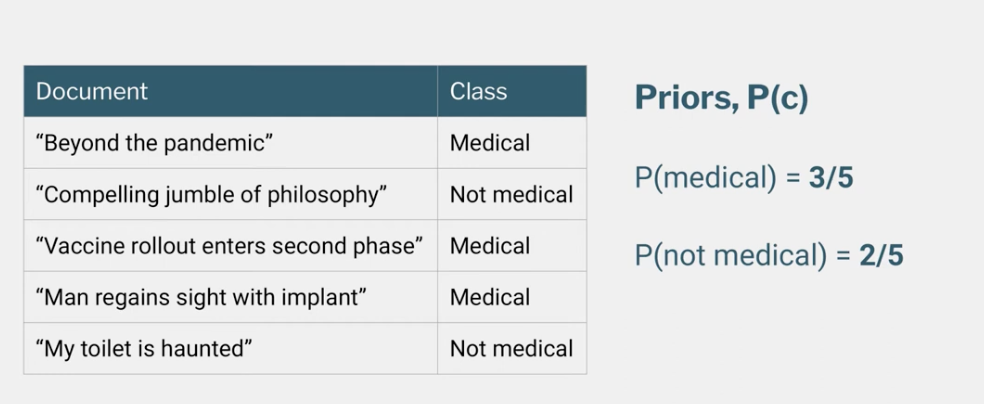

In [20]:
display.Image(r"./png/Naive_Bayes1.png")

We define a Bunch better than pd.DataFrame for NLP

In [180]:
class Bunch(dict):
    """Container for a dataset with attributes.
    The Bunch class inheritates of the dict methods
    to access the values and the attributes."""
    def __init__(self, **kwargs):
        super().__init__(kwargs)

    def __setattr__(self, key, value):
        self[key] = value

    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError:
            raise AttributeError(key)

In [277]:
documents = ["Beyond the pandemic",
             "Compelling jumble of philosophy",
             "Vaccine rollout enters second phase",
             "Man regains sight with implant",
             "My toilet is haunted"]

classes = ["Medical",
           "Not Medical",
           "Medical",
           "Medical",
           "Not Medical"]

# Create a Buch object to store the documents and the classes
data = Bunch(documents=documents, classes=classes)

# Accéder aux documents et aux classes
print("Documents:", data.documents)
print("Classes:", data.classes)

Documents: ['Beyond the pandemic', 'Compelling jumble of philosophy', 'Vaccine rollout enters second phase', 'Man regains sight with implant', 'My toilet is haunted']
Classes: ['Medical', 'Not Medical', 'Medical', 'Medical', 'Not Medical']


In [191]:
nb_documents = len(data.documents)
print(nb_documents)

nb_class_occurrences = sum(1 for classe in data.classes if classe == 'Medical')
print(nb_class_occurrences)

5
3


In [194]:
def prior(class_to_filter) -> float:
    """Returns the prior P(c)"""
    nb_documents = len(data.documents)
    nb_class_occurrences = sum(1 for classe in data.classes if classe == class_to_filter)
    p = nb_class_occurrences / nb_documents
    return p

In [195]:
prior("Medical"), prior("Not Medical")

(0.6, 0.4)

In [240]:
# Filter the documents of the classe 'Medical'
class_to_filter = "Medical"
documents_filters = [doc for doc, classe in zip(data.documents, data.classes) if classe == class_to_filter]
vocab_class = ' '.join([doc for doc in documents_filters]).split(' ')
vocab_class

def vocabulary_class(class_to_filter) -> list:
    "Returns the list of the words in the class"
    documents_filters = [doc for doc, classe in zip(data.documents, data.classes) if classe == class_to_filter] 
    vocab_class = ' '.join([doc.lower() for doc in documents_filters]).split(' ')
    return vocab_class

print(vocabulary_class('Medical'))


['beyond', 'the', 'pandemic', 'vaccine', 'rollout', 'enters', 'second', 'phase', 'man', 'regains', 'sight', 'with', 'implant']


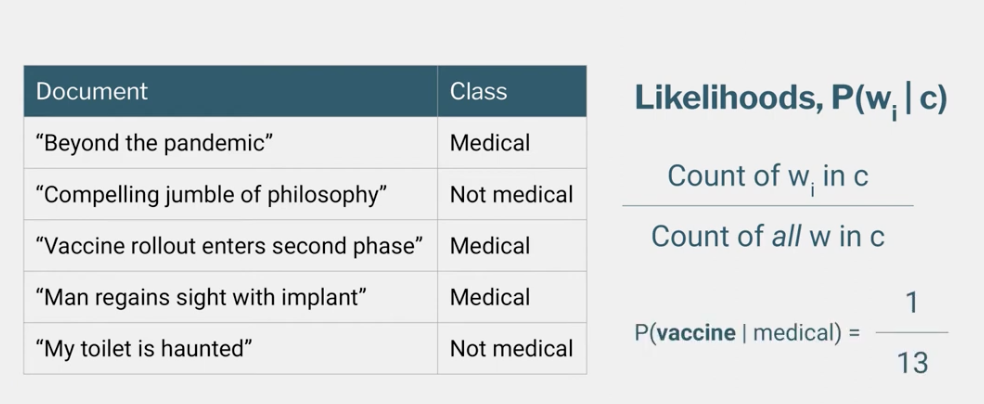

In [241]:
display.Image(r"./png/Naive_Bayes2.png")

In [242]:
sum(1 for word in vocabulary_class("Medical") if word.lower() == "vaccine")

1

In [243]:
all_vocabulaire = ' '.join([elem for elem in data.documents]).split(' ')
len(all_vocabulaire)

21

In [244]:
print(vocabulary_class("Medical"))
print(len(vocabulary_class('Medical')))

from collections import Counter
compteur = Counter(vocabulary_class('Medical'))
print(compteur)
print(compteur['Vaccine'])

['beyond', 'the', 'pandemic', 'vaccine', 'rollout', 'enters', 'second', 'phase', 'man', 'regains', 'sight', 'with', 'implant']
13
Counter({'beyond': 1, 'the': 1, 'pandemic': 1, 'vaccine': 1, 'rollout': 1, 'enters': 1, 'second': 1, 'phase': 1, 'man': 1, 'regains': 1, 'sight': 1, 'with': 1, 'implant': 1})
0


In [245]:
from collections import Counter
wi_in_c = Counter(vocabulary_class('Medical'))['Vaccine']
wi_in_c

0

In [284]:
def p_likelihood(word, class_to_filter) -> float:
    """Takes a word and a classe and return the likelihood p(word | class)"""
    from collections import Counter
    
    # count all w in c
    all_w_in_c = len(vocabulary_class(class_to_filter))
    
    # count w_i in c
    wi_in_c = Counter(vocabulary_class(class_to_filter))[word.lower()]
    
    p = wi_in_c / all_w_in_c
    return p

p_likelihood('Vaccine', 'Medical')

0.07692307692307693

In [285]:
p_likelihood('Vaccine', "Medical")

0.07692307692307693

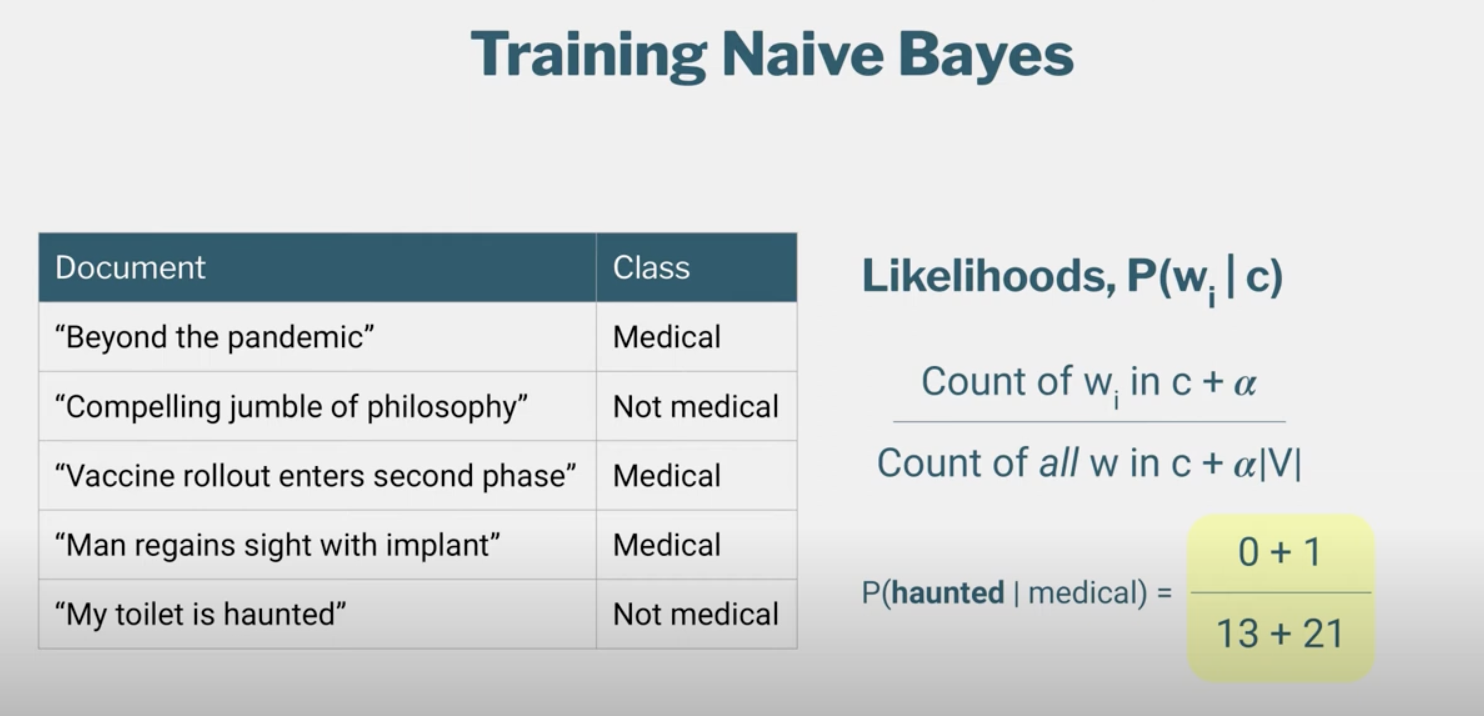

In [347]:
display.Image(r"./png/Naive_Bayes3.png")

In [292]:
def p_likelihood(word, class_to_filter, alpha=1) -> float:
    """Takes a word and a classe and return the likelihood p(word | class)"""
    from collections import Counter
    
    # count all words
    all_vocabulary = ' '.join([elem for elem in data.documents]).split(' ')
    v = len(all_vocabulary)

    # count all words in the class
    all_w_in_c = len(vocabulary_class(class_to_filter))
    
    # count words w_i in the class
    wi_in_c = Counter(vocabulary_class(class_to_filter))[word.lower()]
    
    p = (wi_in_c + alpha) / (all_w_in_c + alpha * v)
    return p

p_likelihood('Vaccine', 'Medical')

0.058823529411764705

In [293]:
p_likelihood('trial', 'Not Medical')

0.034482758620689655

In [294]:
np.log(2/34)

np.float64(-2.833213344056216)

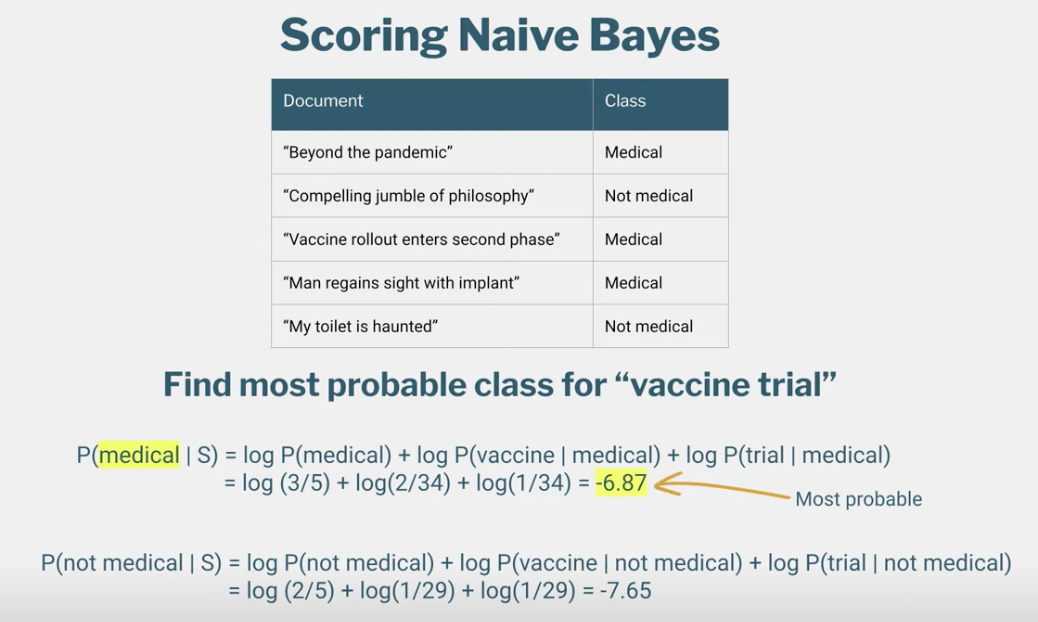

In [295]:
display.Image(r"./png/Naive_Bayes4.png")

In [302]:
test = "vaccine trial"

test = test.split(' ')
print(round(np.log(prior('Medical')) + np.log(p_likelihood(test[0], "Medical")) + np.log(p_likelihood(test[1], "Medical")),2))
print(round(np.log(prior('Not Medical')) + np.log(p_likelihood(test[0], "Not Medical")) + np.log(p_likelihood(test[1], "Not Medical")),2))

-6.87
-7.65


In [348]:
# Fonction pour prédire la classe d'un document
def predict(document, classes):
    """Predict the class of a document"""
    words = document.split(' ')
    max_prob = float('-inf')
    predicted_class = None

    for classe in classes:
        prob = np.log(prior(classe))
        for word in words:
            prob += np.log(p_likelihood(word, classe))

        if prob > max_prob:
            max_prob = prob
            predicted_class = classe

    return predicted_class

# Document de test
test_document = "vaccine trial"

# Prédire la classe du document de test
predicted_class = predict(test_document, ["Medical", "Not Medical"])
print(f"Le document '{test_document}' appartient à la classe '{predicted_class}'.")

Le document 'vaccine trial' appartient à la classe 'Medical'.


In [349]:
predict("vaccine trial", ["Medical", "Not Medical"])

'Medical'

In [24]:
#!pip install matplotlib

In [303]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [304]:
## Load the dataset

# To build our model, we want the training subset only. The training
# subset is what gets downloaded by default but we explicitly
# pass the parameter here for clarity.
training_corpus = fetch_20newsgroups(subset='train')

The training data we downloaded not only includes the posts but also a label ("target") for each post representing its topic.  
The posts are an array of strings while the labels are a corresponding array of numeric labels.

In [306]:
# These are the possible topics a post can belong to.
training_corpus.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [307]:
# These are the labels/targets for each post.
print(training_corpus.target)

[7 4 4 ... 3 1 8]


In [308]:
# The first post along with its corresponding label.
print(training_corpus.data[0])

first_doc_label = training_corpus.target[0]
print('Label for this post: {}'.format(first_doc_label))
print('Corresponding topic: {}'.format(training_corpus.target_names[first_doc_label]))

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Label for this post: 7
Corresponding topic: rec.autos


When starting off with a dataset, it's a good idea to check its distribution.  
In this case, we can see at a glance this dataset is relatively balanced.

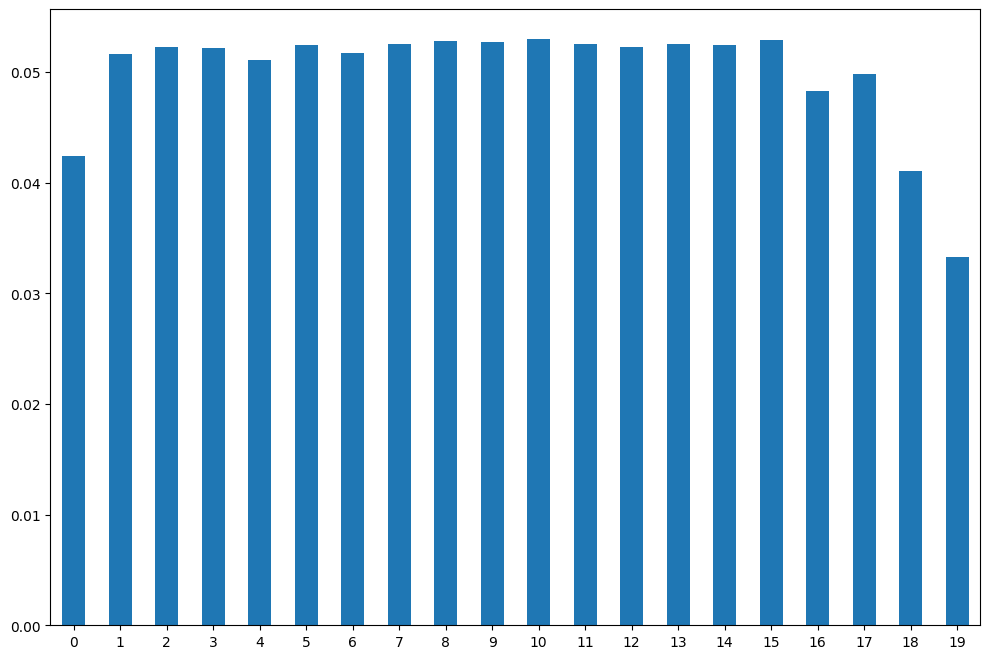

In [310]:
bins, counts = np.unique(training_corpus.target, return_counts=True)
freq_series = pd.Series(counts/len(training_corpus.data))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

In [311]:
# Shuffle, then split the data into train and validation sets. 
# Set the random_state to 1 for reproducibility.
train_data, val_data, train_labels, val_labels = train_test_split(training_corpus.data, training_corpus.target, train_size=0.8, random_state=1) 
print('Training data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(val_data)))

Training data size: 9051
Validation data size: 2263


Now that we have our train-validation split, let's create our spaCy tokenizer.  
Up to this point, we've been using the en_core_web_sm model.

In [312]:
nlp = spacy.load('en_core_web_sm')

By default, it comes up with a preprocessing pipeline with several components enabled.  
We can view these components through the pipe_names attribute.

In [313]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In the previous demos, we individually disabled any component we didn't need.  
For our first pass at building a Naive Bayes classifier, we'll try tokenizing alone. Nothing else.  
Since that's the case, it's easier to instantiate a blank pipeline.
https://spacy.io/api/top-level#spacy.blank

In [314]:
# Create an empty pipeline for english
nlp = spacy.blank('en')

# There should be no pipeline components.
nlp.pipe_names

[]

In [315]:
# Personalized tokenizer:
# For this exercise, we'll remove punctuation and spaces (which
# includes newlines), filter for tokens consisting of alphabetic
# characters only, and return the token text.
def spacy_tokenizer(doc):
  return [t.text for t in nlp(doc) if \
          not t.is_punct and \
          not t.is_space and \
          t.is_alpha]

We'll vectorize using the TfidfVectorizer.

In [316]:
%%time
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 17.4 s, sys: 52.2 ms, total: 17.5 s
Wall time: 17.6 s


Scikit-learn includes a multinomial naive bayes classifier.  
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html  
Calling fit on the classifier and passing it the feature vectors and corresponding labels kicks off the training.

In [317]:
# Instantiate a classifier with the default settings.
nb_classifier = MultinomialNB()
nb_classifier.fit(train_feature_vects, train_labels)
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

Now that we know about the F1 score and have a multiclass problem, let's look at the F1 score on the training data.  
Since the dataset is balanced, accuracy could work here as well but we'll look at F1 since we introduced it.  scikit-learn has a module called metrics we can leverage. 

In [318]:
# Get predictions on training set and calculate F1 score.
# See documentation above for more details on what "macro" means.
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on initial training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

F1 score on initial training set: 0.8982344792497875


So right off the bat, using simple preprocessing and vectorization, and the default settings on the Naive Bayes classifier, we get a model with a decent F1 score. This looks good, but there's a problem.

When we downloaded the training data, we also included headers and footers which contain metadata like subject, and email.

This can be a problem because these fields may be highly informative, causing the model to predict mostly based on the metadata rather than the post content. But if this metadata isn't available at prediction time in production, then our model is going to perform poorly.

So let's retrieve the training data again but without the headers, footers, and post quotes this time. Just raw post text. This makes the problem notably harder for reasons we'll see soon.

In [319]:
# Remove headers, footers, and quotes from training set and resplit.
filtered_training_corpus = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
train_data, val_data, train_labels, val_labels = train_test_split(filtered_training_corpus.data, filtered_training_corpus.target, train_size=0.8, random_state=1) 

In [320]:
# This is what a data point looks like now. Just plain post text.
train_data[0]

"\nI don't know about that...I've used Photoshop 2.5 on both a 486dx-50 and a Quadra\n950...I'd say they are roughly equal.  If anything the 486 was faster."

In [321]:
%%time
# Revectorize our text and retrain our model.
train_feature_vects = vectorizer.fit_transform(train_data)
nb_classifier.fit(train_feature_vects, train_labels)

/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 9.74 s, sys: 27.5 ms, total: 9.77 s
Wall time: 9.88 s


MultinomialNB()

In [322]:
# Recheck F1 score on training data.
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on filtered training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro'))) 

F1 score on filtered training set: 0.791654644597863


Now that we've removed metadata, our F1 score has dropped but still seems ok.  
The next step is to see how well the classifier performs on the validation set.

In [323]:
%%time
# Vectorize the validation data.
val_feature_vects = vectorizer.transform(val_data)

CPU times: user 2.61 s, sys: 9.14 ms, total: 2.62 s
Wall time: 2.7 s


In [324]:
# Predict and evaluate.
val_preds = nb_classifier.predict(val_feature_vects)
print('F1 score on filtered validation set: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

F1 score on filtered validation set: 0.6087677070998413


That's quite a drop in F1 score. Because there are 20 classes involved, let's plot a confusion matrix to see what's going on:

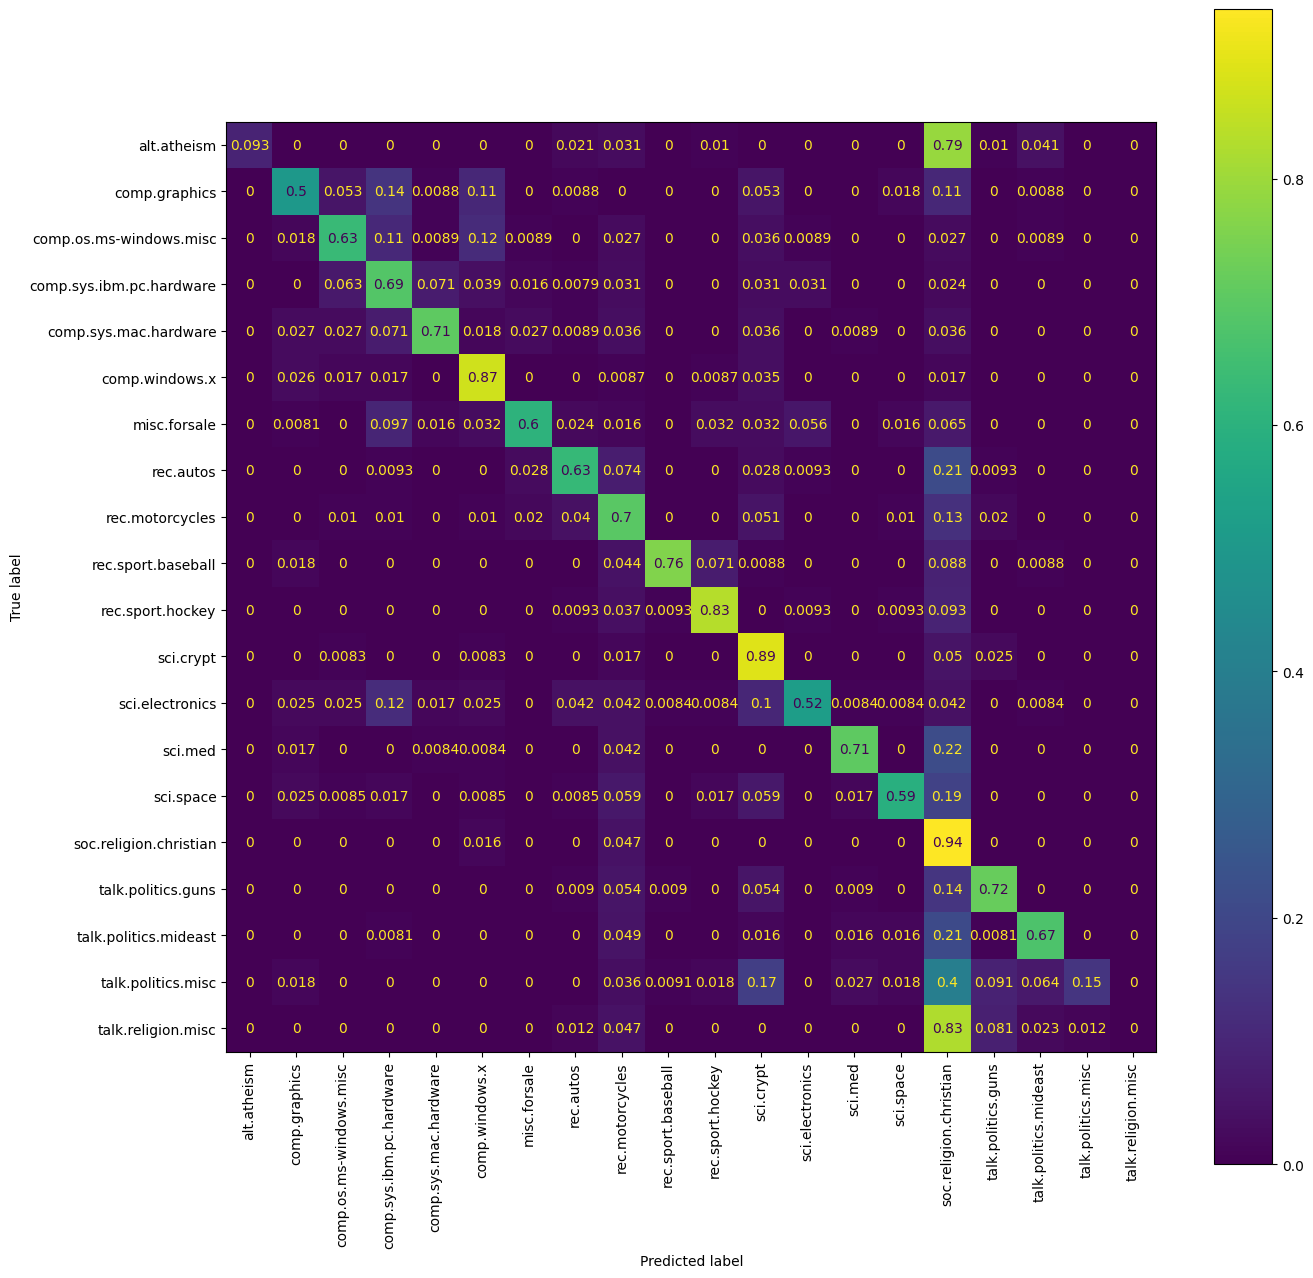

In [325]:
# Set the size of the plot.
fig, ax = plt.subplots(figsize=(15, 15))

# Create the confusion matrix. 
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

On the diagonale the percentage of correct prediction. Outside the diagonale the errors in percentage.

Similar to what we saw in the slides, the y-axis represents the true labels and the x-axis represents the predictions.  
Each square's brightness represents the number of posts assigned to that class.   
What we ideally want is brightness along the diagonal (top-left to bottom-right)   
which represent correct predictions, and little to no brightness anywhere else.  

Looking at the confusion matrix above, we can make a few observations:  
The more specific a topic is, the better the prediction result.   
Hockey and cryptography are good examples. This intuitively makes sense.

Topics with a lot of word overlap tend to have higher errors.  
For example, the majority of atheism and religion.misc posts are classified under christianity.  
In general, the christianity column has a prevalence of brighter squares  
with misclassified posts from politics.misc, politics.mideast, etc.
There's a smaller, secondary cluster of errors around the computer-related topics  
(e.g. posts in electronics being misclassified as hardware).  

Seeing the results of this matrix, at least there are plausible explanations for the discrepancies.

In [326]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       1.00      0.09      0.17        97
           comp.graphics       0.73      0.50      0.59       114
 comp.os.ms-windows.misc       0.74      0.63      0.68       112
comp.sys.ibm.pc.hardware       0.56      0.69      0.61       127
   comp.sys.mac.hardware       0.83      0.71      0.76       112
          comp.windows.x       0.69      0.87      0.77       115
            misc.forsale       0.87      0.60      0.71       124
               rec.autos       0.76      0.63      0.69       108
         rec.motorcycles       0.47      0.70      0.56        99
      rec.sport.baseball       0.96      0.76      0.85       113
        rec.sport.hockey       0.83      0.83      0.83       108
               sci.crypt       0.57      0.89      0.69       120
         sci.electronics       0.82      0.52      0.64       119
                 sci.med       0.89      0.71      0.79       119
         

/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

A few observations:  
Atheism has a perfect precision score but terrible recall,   
signalling that the model was right when it classified something as under atheism,  
but missed the vast majority in the corpus.  
The model didn't classify anything under religion.misc.  
The more specific the topic, the better it tends to do.

#### Improving the model

**Let**'s try to do better. One thing that's likely an issue is the sheer number of features we have relative to how little data there is.

In [327]:
print('Training data size: {}'.format(len(train_data)))
print('Number of training features: {}'.format(len(train_feature_vects[0].toarray().flatten())))

Training data size: 9051
Number of training features: 51637


So we can experiment with:  
Removing stop words because topic identification likely depends more on keywords rather than sequences in this case.  
Using the token lemma rather than the text.

We can't get away with the blank pipeline since we need a bunch of components to generate the lemma.  
So we'll load the en_core_web_sm model and disable named-entity recognition and parsing in the tokenizer callback.

In [328]:
nlp = spacy.load('en_core_web_sm')

In [329]:
unwanted_pipes = ['ner', 'parser']

# Further remove stop words and take the lemma instead of token text.
def spacy_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha]

We need to re-vectorize the training set with the new tokenizer.  
Because there are certain components enabled, this is going to take longer (a few mins).  
Take a look at these link for ways to further optimize spaCy's pipeline:  
https://spacy.io/usage/processing-pipelines#processing  
https://spacy.io/api/language#pipe

YouTube video from spaCy on using nlp.pipe: Speed up spaCy pipelines via nlp.pipe - spaCy shorts  
Tuning nlp.pipe: https://stackoverflow.com/questions/65850018/processing-text-with-spacy-nlp-pipe  
Passing a list of pre-processed tokens to TfidfVectorizer:  
https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/

In [330]:
%%time
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 1min 11s, sys: 2.28 s, total: 1min 14s
Wall time: 1min 14s


In [331]:
# Check the number of features now.
print('Number of training features: {}'.format(len(train_feature_vects[0].toarray().flatten())))

Number of training features: 42803


**A** little better but still not great. Let's retrain our classifier and see what happens.

In [332]:
nb_classifier.fit(train_feature_vects, train_labels)
train_preds = nb_classifier.predict(train_feature_vects)
print('Training F1 score with fewer features: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

Training F1 score with fewer features: 0.839229137359691


Check classifier performance on validation set.

In [333]:
%%time
val_feature_vects = vectorizer.transform(val_data)

CPU times: user 16.9 s, sys: 497 ms, total: 17.4 s
Wall time: 17.6 s


In [334]:
val_preds = nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.673409559015635


We managed to squeeze out a few percentage points. Let's look at the confusion matrix and classification report.

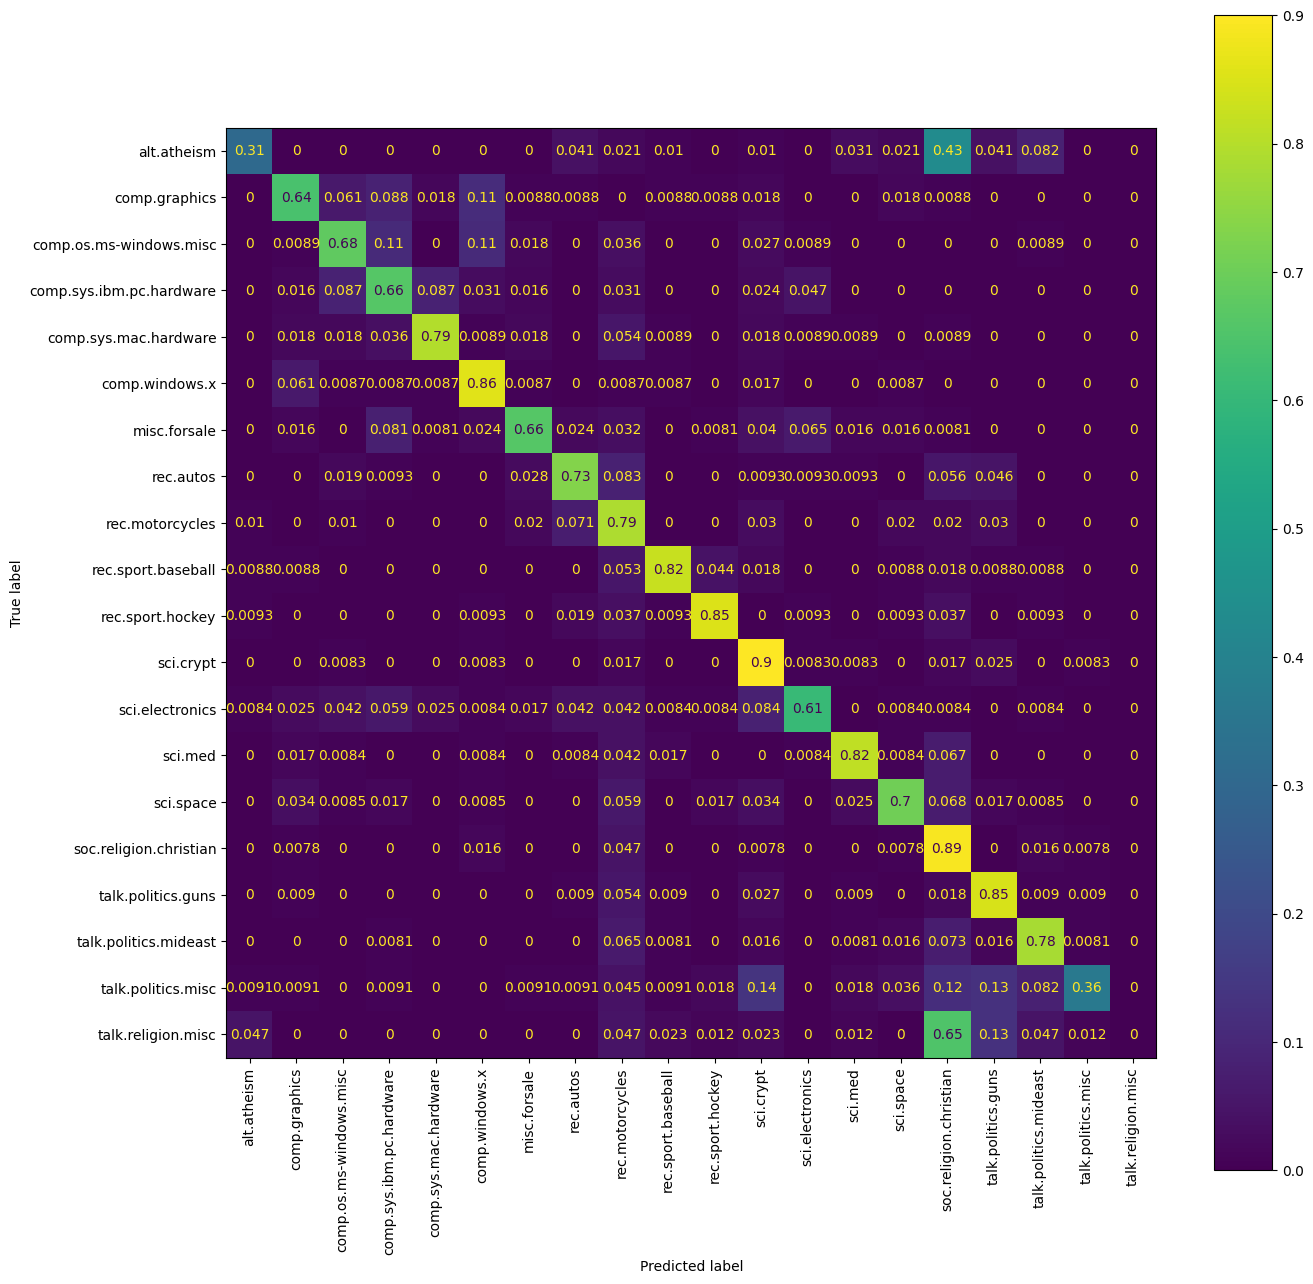

In [335]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [336]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.77      0.31      0.44        97
           comp.graphics       0.73      0.64      0.68       114
 comp.os.ms-windows.misc       0.70      0.68      0.69       112
comp.sys.ibm.pc.hardware       0.63      0.66      0.65       127
   comp.sys.mac.hardware       0.83      0.79      0.81       112
          comp.windows.x       0.71      0.86      0.78       115
            misc.forsale       0.84      0.66      0.74       124
               rec.autos       0.76      0.73      0.75       108
         rec.motorcycles       0.47      0.79      0.59        99
      rec.sport.baseball       0.88      0.82      0.85       113
        rec.sport.hockey       0.88      0.85      0.86       108
               sci.crypt       0.64      0.90      0.75       120
         sci.electronics       0.78      0.61      0.68       119
                 sci.med       0.86      0.82      0.84       119
         

/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In the confusion matrix, the squares in the christian column have dimmed, signalling fewer classification errors. And although atheism now classifies better, that topic along with religion.misc remain big sources of overall errors.
Let's assume for now that we can't get or generate more data.

Next, we can try tuning a hyperparameter on the classifier. For Naive Bayes, we'll adjust the the alpha smoothing factor we discussed in the slides. But rather than trying a bunch ourselves, we can use a combination of Grid Search and Cross Validation.  

- Grid search involves having the computer try a list of hyperparameter values for us, and returning the best performing value. The list of hyperparameter values to try is supplied by us. Grid search is a basic technique and there are a number of other techniques such as random search and bayesian optimization.  

- Cross validation is a way to evaluate machine learning models on limited datasets. It randomly splits the data into k-groups. One group is set aside as the holdout set while the classifier trains a model on the remaining groups. The resulting model is then used on the holdout group and the score recorded. This repeats itself until all groups have been used as a holdout set and an average score returned.  

Scikit-learn has modules to handle both for us:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://scikit-learn.org/stable/modules/grid_search.html#grid-search
https://scikit-learn.org/stable/modules/cross_validation.html

In [337]:
# The alpha values to try.
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0,],}

# Instantiate the search with the model we want to try and fit it on the training data.
multinomial_nb_grid = model_selection.GridSearchCV(MultinomialNB(), param_grid=params, scoring='f1_macro', n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(train_feature_vects, train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........................alpha=0.01;, score=0.737 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.737 total time=   0.0s
[CV 2/5] END ........................alpha=0.01;, score=0.738 total time=   0.0s
[CV 3/5] END ........................alpha=0.01;, score=0.735 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.741 total time=   0.0s
[CV 4/5] END ........................alpha=0.01;, score=0.744 total time=   0.0s
[CV 1/5] END .........................alpha=0.5;, score=0.690 total time=   0.0s
[CV 2/5] END .........................alpha=0.5;, score=0.703 total time=   0.0s
[CV 3/5] END .........................alpha=0.5;, score=0.674 total time=   0.1s
[CV 4/5] END .........................alpha=0.5;, score=0.699 total time=   0.1s
[CV 5/5] END ........................alpha=0.01;, score=0.768 total time=   0.1s
[CV 1/5] END .........................alpha=0.1;,

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
             scoring='f1_macro', verbose=5)

The resulting GridSearchCV object has a number of attributes you can explore:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

We're interested in the best performing parameter value(s).

In [338]:
print('Best parameter value(s): {}'.format(multinomial_nb_grid.best_params_))

Best parameter value(s): {'alpha': 0.01}


You can directly access the best estimator found by the search. Let's try using it on the validation set.

In [339]:
best_nb_classifier = multinomial_nb_grid.best_estimator_
val_preds = best_nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.7343805683794756


So we got another decent jump after using the the optimal alpha value. Let's look at the confusion matrix (using the best estimator so far) and classification report again.

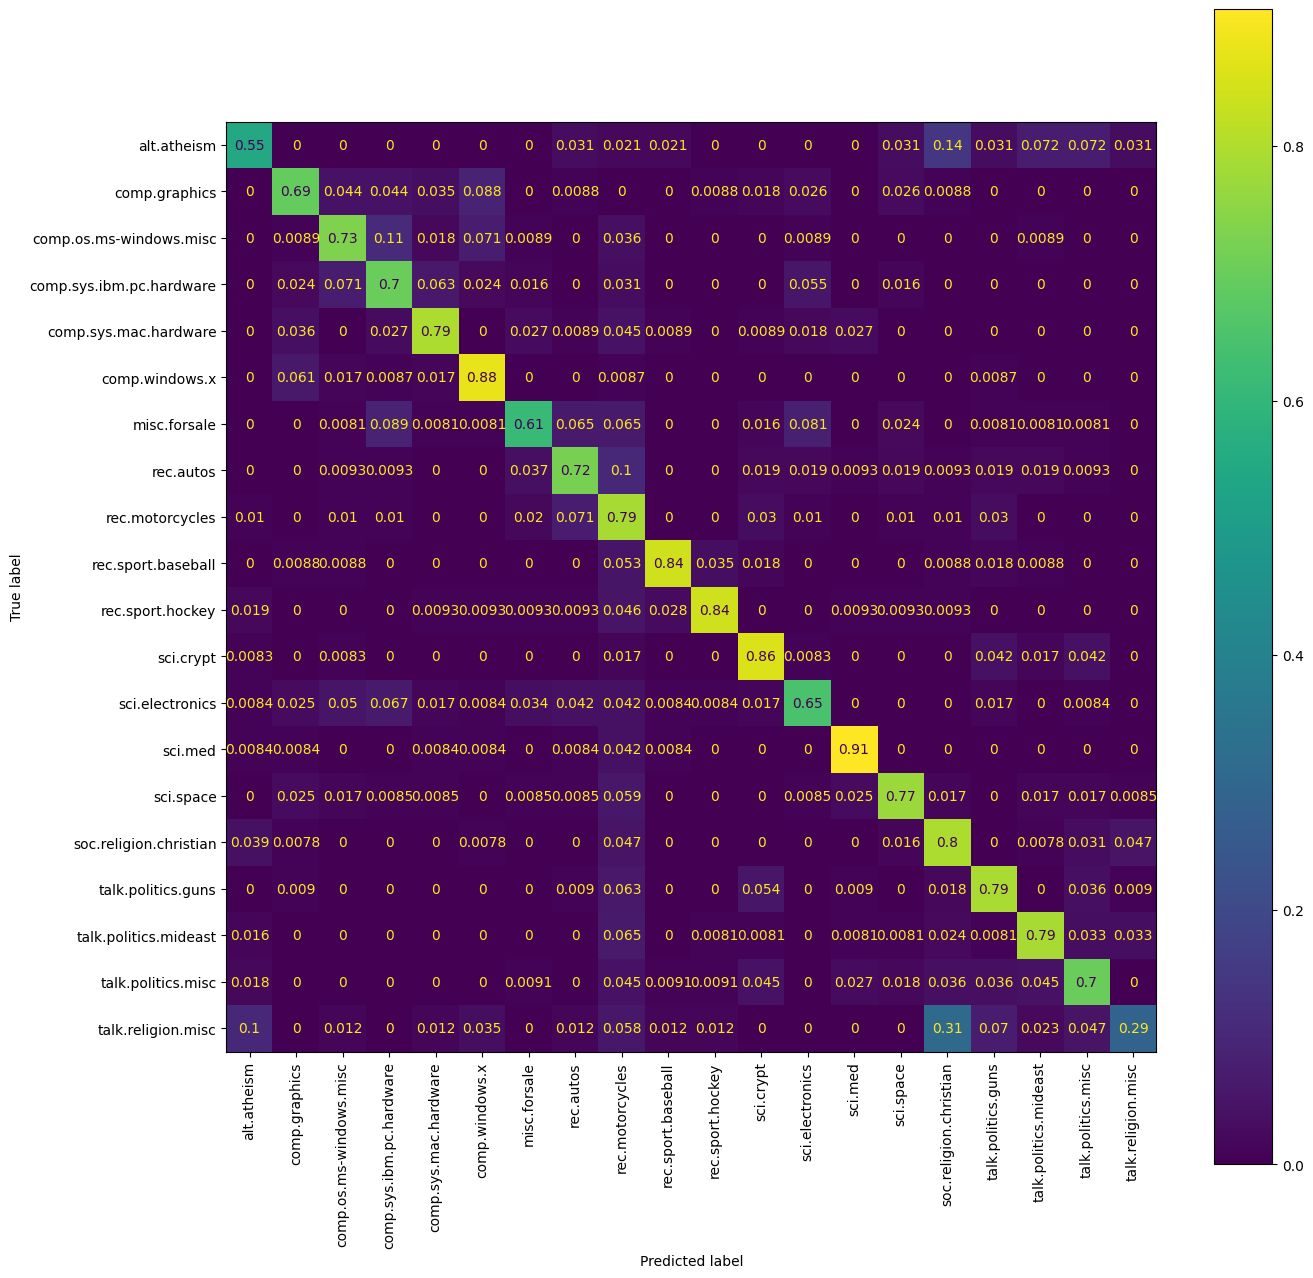

In [340]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(best_nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=filtered_training_corpus.target_names, xticks_rotation='vertical', ax=ax)

In [341]:
print(metrics.classification_report(val_labels, val_preds, target_names=filtered_training_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.69      0.55      0.61        97
           comp.graphics       0.76      0.69      0.72       114
 comp.os.ms-windows.misc       0.73      0.73      0.73       112
comp.sys.ibm.pc.hardware       0.67      0.70      0.69       127
   comp.sys.mac.hardware       0.79      0.79      0.79       112
          comp.windows.x       0.78      0.88      0.82       115
            misc.forsale       0.80      0.61      0.69       124
               rec.autos       0.72      0.72      0.72       108
         rec.motorcycles       0.45      0.79      0.57        99
      rec.sport.baseball       0.90      0.84      0.87       113
        rec.sport.hockey       0.91      0.84      0.88       108
               sci.crypt       0.80      0.86      0.83       120
         sci.electronics       0.73      0.65      0.69       119
                 sci.med       0.89      0.91      0.90       119
         

A few observations from this one:  

1. Atheism and religion.misc are doing much better though still a source of errors.  
2. The christian column has dimmed further in the other categories.  

Given the small data size and the soft borders around various topics, what we have now is probably good enough. A few further ideas to explore:  

- Augment the training data with posts from similar subreddits.
- Incorporate n-grams.
- Remove the misc categories if your goal allows it.
- Merge a few categories with large overlap together if your goal allows it.
- Use the CountVectorizer instead of the TfidfVectorizer.
- Play around with adding more stop words after seeing which ones are the most prevalent.
- Play with the min_df, max_df, and max_features in the TFidfVectorizer.
- Use a dimensionality reduction technique like Singular Value Decomposition (SVD) or dense word vectors which we'll cover in Part II.  
- Try other models: logistic regression, support vector machines, random forests, SGD classifier.  

My guess is that, aside from merging categories, it'll be hard to do much better than what we have given the nature of the data.  

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://scikit-learn.org/stable/modules/svm.html#svm-classification
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

For idea (6), we can use the function below to view the most commonly occurring words in each category.

In [342]:
def show_top_words(classifier, vectorizer, categories, top_n):
  feature_names = np.asarray(vectorizer.get_feature_names_out())
  for i, category in enumerate(categories):
    prob_sorted = classifier.feature_log_prob_[i, :].argsort()[::-1]
    print("%s: %s" % (category, " ".join(feature_names[prob_sorted[:top_n]])))

In [63]:
show_top_words(best_nb_classifier, vectorizer, filtered_training_corpus.target_names, 10)

alt.atheism: god religion atheist people think say atheism post belief believe
comp.graphics: file graphic image thank program format look know color need
comp.os.ms-windows.misc: window file driver problem use program card thank font do
comp.sys.ibm.pc.hardware: drive card controller bus scsi monitor ide mb thank pc
comp.sys.mac.hardware: mac apple drive problem monitor card thank work simms quadra
comp.windows.x: x window server widget motif application use run thank display
misc.forsale: sale offer sell shipping price new include email condition drive
rec.autos: car engine drive like dealer good new buy oil price
rec.motorcycles: bike ride motorcycle dod helmet like rider go think know
rec.sport.baseball: game year team baseball win hit player run think fan
rec.sport.hockey: game team play hockey player season playoff nhl year win
sci.crypt: key encryption chip clipper government system nsa phone escrow bit
sci.electronics: power use circuit know like work chip ground try line
sci.m

As a sanity check, we can use scikit-learns DummyClassifier which can make predictions using strategies such as "just guess the most frequently occurring class" or "make random guesses".  
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [343]:
# Train a dummy classifier which just guesses the most frequent class.
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_feature_vects, train_labels)
dummy_clf.score(val_feature_vects, val_labels)

0.043747238179407864

In [344]:
# Train a dummy classifier which just guesses a class randomly.
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(train_feature_vects, train_labels)
dummy_clf.score(val_feature_vects, val_labels)

0.04507291206363235

#### Create the final Naive Bayes Model

Let's train the classifier we'll use on the test set. We'll use the entire original training set (including validation data) and the ideal alpha param.  

We'll also use scikit-learn's Pipeline to specify a series of transformation and training steps so we can vectorize and fit a model with one call. Creating a few of these pipelines can help speed up your development and stay organized:  

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [345]:
text_classifier = Pipeline([
  ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
  ('classifier', MultinomialNB(alpha=0.01))
])

In [346]:
%%time
text_classifier.fit(filtered_training_corpus.data, filtered_training_corpus.target)

/Users/davidtbo/Documents/Data_Science/28_NLP/spaCy/env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 1min 22s, sys: 2.38 s, total: 1min 25s
Wall time: 1min 25s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x1216165c0>)),
                ('classifier', MultinomialNB(alpha=0.01))])

Download the 20 newsgroups test dataset.

In [129]:
filtered_test_corpus = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

We can now pass the raw test data directly to the classifier.

In [130]:
%%time
test_preds = text_classifier.predict(filtered_test_corpus.data)

CPU times: user 57.2 s, sys: 2.95 s, total: 1min
Wall time: 1min 1s


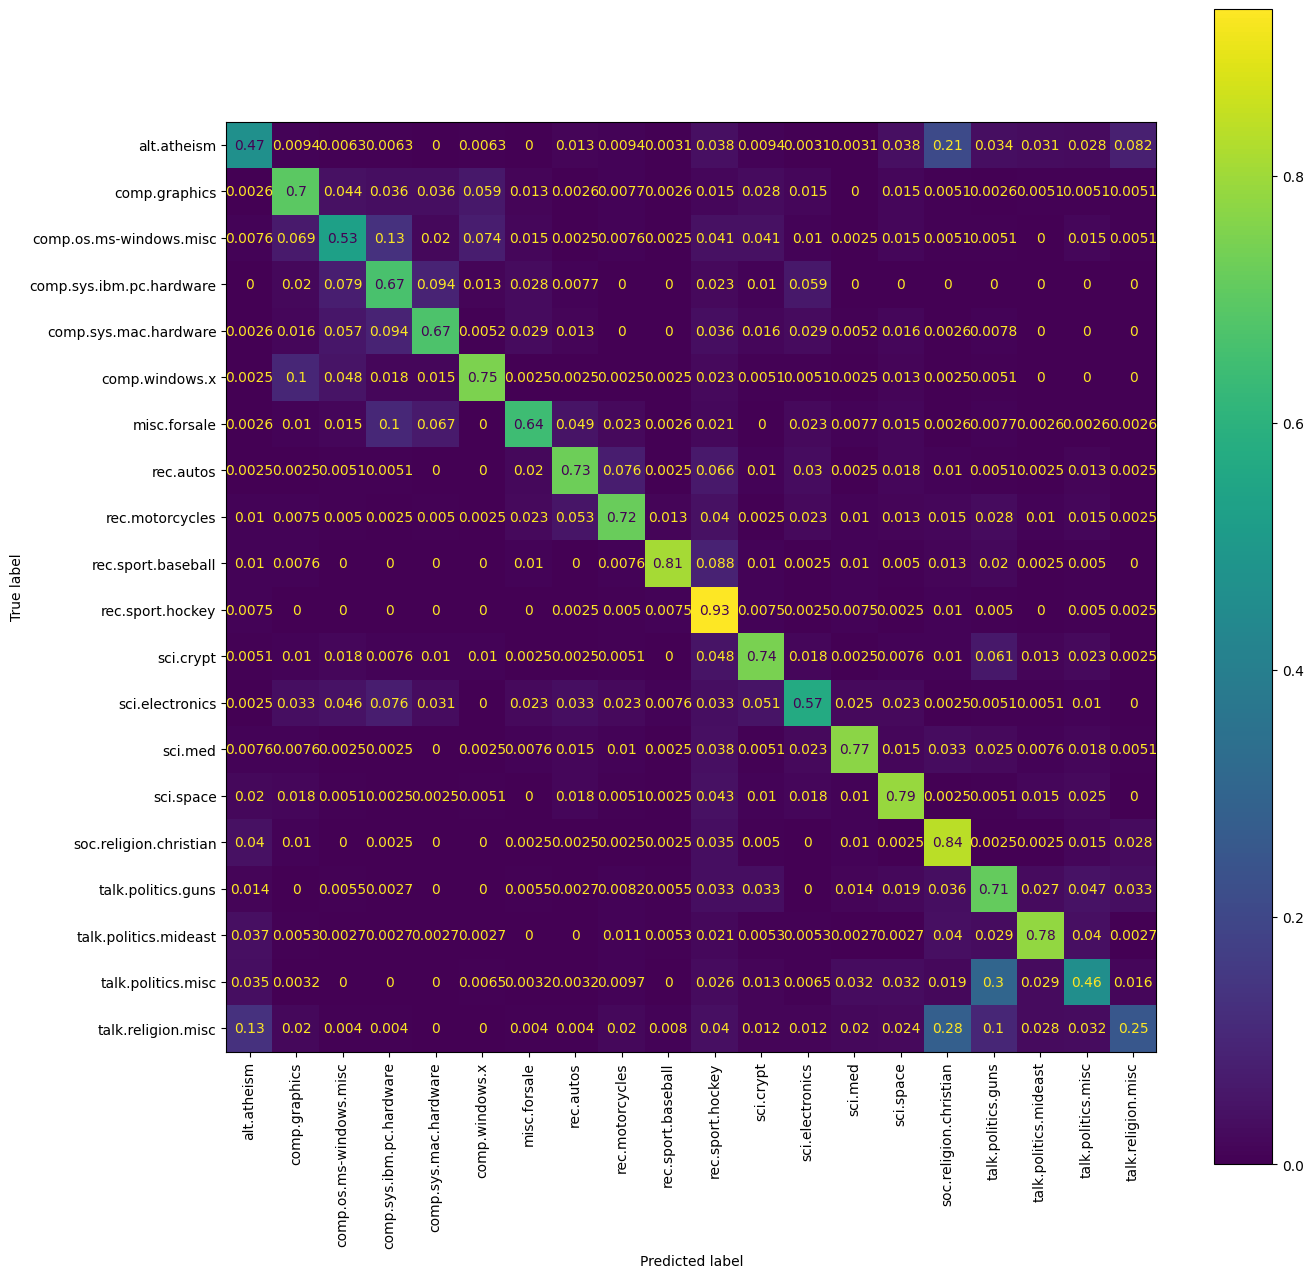

CPU times: user 315 ms, sys: 22.3 ms, total: 337 ms
Wall time: 340 ms


In [131]:
%%time
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(filtered_test_corpus.target, test_preds, normalize='true', display_labels=filtered_test_corpus.target_names, xticks_rotation='vertical', ax=ax)
plt.show()

Looking at the confusion matrix for test data classification,  
we see there are still a few brighter clusters around the soft politics/religion area as well as the finer-grained   
computer-related topics which drag the overall accuracy down.   
This is reflected in the classification report as well.   
Overall, the other topics look ok given the data we have.

In [132]:
def classify_text(clf, doc, labels=None):
  probas = clf.predict_proba([doc]).flatten()
  max_proba_idx = np.argmax(probas)
  
  if labels:
    most_proba_class = labels[max_proba_idx]
  else:
    most_proba_class = max_proba_idx

  return (most_proba_class, probas[max_proba_idx])

The strings below were taken at random from subreddits that have corresponding topics (e.g. r/space, r/cars, etc).

In [133]:
# Post from r/medicine.
s = "Hello everyone so am doing my thesis on Ischemic heart disease have been using online articles and textbooks mostly Harrisons internal med. could u recommended me some source specifically books where i can get more about in depth knowledge on IHD."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.med', np.float64(0.7210299189355043))

In [134]:
# Post from r/space.
s = "First evidence that water can be created on the lunar surface by Earth's magnetosphere. Particles from Earth can seed the moon with water, implying that other planets could also contribute water to their satellites."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.space', np.float64(0.9670411415255361))

In [135]:
# Post from r/cars.
s = "New Toyota 86 Launch Reportedly Delayed to 2022, CEO Doesn't Want a Subaru Copy"
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('rec.autos', np.float64(0.8431430100739286))

In [136]:
# Post from r/electronics.
s = "My First Ever Homemade PCB. My SMD Soldering Skills Aren't Great, But I'm Quite Proud of it."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('sci.electronics', np.float64(0.8335854629240337))

These are a few made-up statements with low probability which could belong to anything. In these situations, they can be dealt with as special cases.

In [137]:
s = "I don't know if that's a good idea."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('comp.sys.ibm.pc.hardware', np.float64(0.08082894771002713))

In [138]:
s = "Hold on for dear life."
classify_text(text_classifier, s, filtered_test_corpus.target_names)

('soc.religion.christian', np.float64(0.27355777686971455))

Note:  
Keep in mind that Naive Bayes is good at returning the most probable class but is regarded as a poor estimator  
because of its naive assumption of independence (i.e. the actual probability values aren't very reliable).